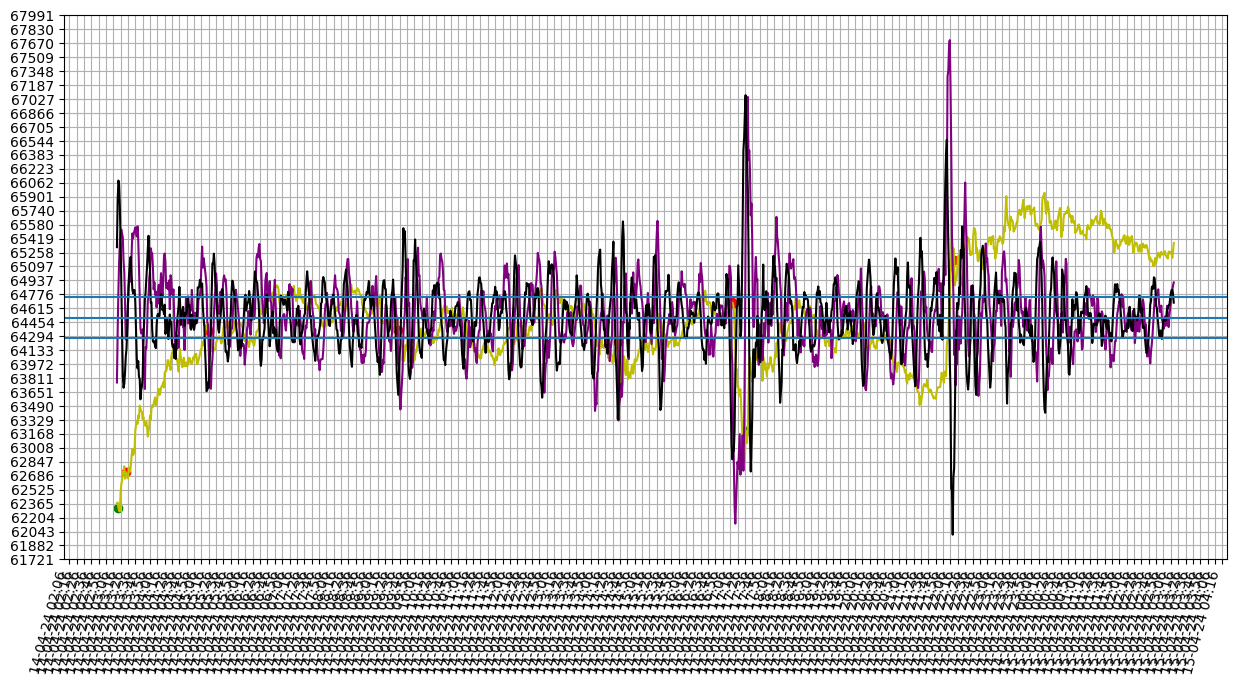

In [10]:
import pandas as pd
# import os
import cupy as cp
import numpy as np
from datetime import datetime
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
import time
from IPython.display import clear_output

client = Client()

smooth_interval = 15
smooth_exp = 3

rango = 0
std_mult = 135000
pdi_mult = 1000
sdi_mult = 250000
z_aprox = 0.1
pmax_idx = 0
pmin_idx = 0

# while True:
#     clear_output(wait=True)
recent_data = pd.DataFrame(client.get_historical_klines('BTCTUSD', '1m', '24 hours ago UTC'))
recent_data = recent_data.iloc[:, :6]
recent_data.columns = ['Tiempo', 'Open', 'High', 'Low', 'Close', 'Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo, unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

# Convert to Cupy arrays
open_prices = cp.array(recent_data.Open).get()
time_diff = cp.array((np.diff(recent_data.Tiempo)/np.timedelta64(1, 's')).astype(float)).get()



recent_data['Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(open_prices, smooth_interval, smooth_exp))
recent_data['Primer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((open_prices[1:] - open_prices[:-1]) / time_diff)])
recent_data['PD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Primer_Derivada, smooth_interval, smooth_exp))
recent_data['Segunda_Derivada'] = np.concatenate([np.zeros(1),cp.asnumpy((recent_data.PD_Interpolacion[1:].reset_index(drop=True) - recent_data.PD_Interpolacion[:-1])/time_diff)])
recent_data['SD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Segunda_Derivada, smooth_interval, smooth_exp))
recent_data['Tercer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((recent_data.SD_Interpolacion[1:].reset_index(drop=True) - recent_data.SD_Interpolacion[:-1])/time_diff)])
recent_data['TD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Tercer_Derivada, smooth_interval, smooth_exp))

# recent_data['Interpolacion'] =    np.concatenate([np.zeros(0),cp.asnumpy(sc.signal.savgol_filter(open_prices, smooth_interval, smooth_exp))])
# recent_data['Primer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((open_prices[1:] - open_prices[:-1]) / time_diff)])
# recent_data['PD_Interpolacion'] = np.concatenate([np.zeros(0),cp.asnumpy(sc.signal.savgol_filter(recent_data.Primer_Derivada, smooth_interval, smooth_exp))])
# recent_data['Segunda_Derivada'] = np.concatenate([np.zeros(1),cp.asnumpy((recent_data.PD_Interpolacion[1:].reset_index(drop=True) - recent_data.PD_Interpolacion[:-1])/time_diff)])
# recent_data['SD_Interpolacion'] = np.concatenate([np.zeros(0),cp.asnumpy(sc.signal.savgol_filter(recent_data.Segunda_Derivada, smooth_interval, smooth_exp))])
# recent_data['Tercer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((recent_data.SD_Interpolacion[1:].reset_index(drop=True) - recent_data.SD_Interpolacion[:-1])/time_diff)])
# recent_data['TD_Interpolacion'] = np.concatenate([np.zeros(0),cp.asnumpy(sc.signal.savgol_filter(recent_data.Tercer_Derivada, smooth_interval, smooth_exp))])


initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()), '%Y-%m-%d %H:%M:%S')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()), '%Y-%m-%d %H:%M:%S')].index.item() - rango

lista_min_max = recent_data.iloc[initial_date_index:final_date_index][(recent_data.iloc[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data.iloc[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

import cupy as cp

max_points_idx = []
min_points_idx = []

for PMSD in indices_min_max:
    condition1 = (cp.array(recent_data['SD_Interpolacion'][PMSD:PMSD+1]) > 0) & (cp.array(recent_data['PD_Interpolacion'][PMSD:PMSD+1]) > 0)
    condition2 = (cp.array(recent_data['SD_Interpolacion'][PMSD:PMSD+1]) < 0) & (cp.array(recent_data['PD_Interpolacion'][PMSD:PMSD+1]) < 0)
    
    if cp.any(condition1):
        pmax_mask = (cp.abs(recent_data['SD_Interpolacion'][PMSD]*100) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][PMSD])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
        
        for i in range(rango+1):
            idx1 = PMSD - i
            idx2 = PMSD + i
            
            pmax_mask1 = (cp.array(recent_data['SD_Interpolacion'][idx1]) > pmax) & (cp.abs(recent_data['SD_Interpolacion'][idx1]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & ((cp.array(recent_data['PD_Interpolacion'][idx1])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmax_mask1:
                pmax_idx = idx1
                pmax = recent_data.SD_Interpolacion[idx1]
                
            pmax_mask2 = (cp.array(recent_data['SD_Interpolacion'][idx2]) > pmax) & (cp.abs(recent_data['SD_Interpolacion'][idx2]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & ((cp.array(recent_data['PD_Interpolacion'][idx2])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmax_mask2:
                pmax_idx = idx2
                pmax = recent_data.SD_Interpolacion[idx2]
        max_points_idx.append(pmax_idx)
        
    elif cp.any(condition2):
        pmin_mask = (cp.abs(recent_data['SD_Interpolacion'][PMSD]*100) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][PMSD])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
        
        for i in range(rango+1):
            idx1 = PMSD - i
            idx2 = PMSD + i
            
            pmin_mask1 = (cp.array(recent_data['SD_Interpolacion'][idx1]) < pmin) & (cp.abs(recent_data['SD_Interpolacion'][idx1]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][idx1])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmin_mask1:
                pmin_idx = idx1
                pmin = recent_data.SD_Interpolacion[idx1]
            pmin_mask2 = (cp.array(recent_data['SD_Interpolacion'][idx2]) < pmin) & (cp.abs(recent_data['SD_Interpolacion'][idx2]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][idx2])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmin_mask2:
                pmin_idx = idx2
                pmin = recent_data.SD_Interpolacion[idx2]
        min_points_idx.append(pmin_idx)

max_points_idx = cp.asnumpy(cp.array(list(set(max_points_idx))))
min_points_idx = cp.asnumpy(cp.array(list(set(min_points_idx))))
max_points_idx.sort()
min_points_idx.sort()


mp = recent_data.Open[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index - rango:final_date_index + rango], recent_data.Open[initial_date_index - rango:final_date_index + rango].multiply(1), color='y')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index], recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(1000)+mp, 'purple')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index], recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(250000)+mp, color='k')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx], recent_data.Open.iloc[max_points_idx], color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx], recent_data.Open.iloc[min_points_idx], color='r')
plt.grid(visible=True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.gca().yaxis.set_major_locator(ticker.LinearLocator(40))
plt.gcf().autofmt_xdate()

plt.grid(which='minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(cp.std(recent_data.SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - cp.std(recent_data.SD_Interpolacion)*std_mult)
plt.show()

In [13]:
import time
start_all = time.time()
import pandas as pd
# import os
import cupy as cp
import numpy as np
from datetime import datetime
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from IPython.display import clear_output

client = Client()

smooth_interval = 15
smooth_exp = 3

rango = 0
std_mult = 135000
pdi_mult = 1000
sdi_mult = 250000
z_aprox = 0.1
pmax_idx = 0
pmin_idx = 0

# while True:
#     clear_output(wait=True)
recent_data = pd.DataFrame(client.get_historical_klines('BTCTUSD', '1m', '10 days ago UTC'))
recent_data = recent_data.iloc[:, :6]
recent_data.columns = ['Tiempo', 'Open', 'High', 'Low', 'Close', 'Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo, unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

start = time.time()
# recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,smooth_exp)
# recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
# recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
# recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
# recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
# recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
# recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,smooth_exp)   # 0.34596872329711914
def savgol_filter(y, window_size, poly_order):
    half_window = window_size // 2
    order_range = np.arange(poly_order+1)
    weight = np.zeros((window_size, poly_order+1))
    
    for i in range(-half_window, half_window+1):
        weight[i+half_window, :] = [i**j for j in order_range]
    
    weights = cp.linalg.pinv(cp.array(weight)).T.sum(axis=0)
    
    smoothed = cp.convolve(cp.array(weights), cp.array(y), mode='valid')
    
    return smoothed #smoothed_padded

def calculate_derivatives(interpolacion, times, derivative):
    d_interpolacion = cp.diff(interpolacion) / time_diff[2+derivative:]
    return d_interpolacion


open_prices = cp.array(recent_data['Open'].values).get()
time_diff = cp.array((np.diff(recent_data.Tiempo)/np.timedelta64(1, 's')).astype(float)).get()

start = time.time()
interpolacion = cp.array(savgol_filter(open_prices, smooth_interval, 3)).get()
primer_derivada = calculate_derivatives(interpolacion, time_diff, 1)
pd_interpolacion = savgol_filter(primer_derivada, smooth_interval, 3)
segunda_derivada = calculate_derivatives(pd_interpolacion, time_diff, 5)
sd_interpolacion = savgol_filter(segunda_derivada, smooth_interval, 3)
tercer_derivada = calculate_derivatives(sd_interpolacion, time_diff, 9)
td_interpolacion = savgol_filter(tercer_derivada, smooth_interval, 3)
recent_data['Interpolacion'] = np.concatenate([np.zeros(3),interpolacion])
recent_data['Primer_Derivada'] = np.concatenate([np.zeros(4),primer_derivada])
recent_data['PD_Interpolacion'] = np.concatenate([np.zeros(7),pd_interpolacion])
recent_data['Segunda_Derivada'] = np.concatenate([np.zeros(8),segunda_derivada])
recent_data['SD_Interpolacion'] = np.concatenate([np.zeros(11),sd_interpolacion])
recent_data['Tercer_Derivada'] = np.concatenate([np.zeros(12),tercer_derivada])
recent_data['TD_Interpolacion'] = np.concatenate([np.zeros(15),td_interpolacion])
end = time.time()
print(f'Tiempo de derivadas sin cupy: {end - start}')

initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

start = time.time()
lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()
max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

for PMSD in indices_min_max:
    if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0):
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) > abs(np.std(recent_data.Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult)) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > abs(np.std(recent_data.Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult)) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > abs(np.std(recent_data.Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        max_points_idx.append(pmax_idx)
    elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item()) < 0 & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0):
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) < -abs(np.std(recent_data.Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < -abs(np.std(recent_data.Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > abs(np.std(recent_data.Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < -abs(np.std(recent_data.Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        min_points_idx.append(pmin_idx)
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
end = time.time()
print(f'Tiempo de estrategia sin cupy: {end - start}')
end_all = time.time()
print(f'Tiempo total sin cupy: {end_all - start_all}')

TypeError: Unsupported type <class 'numpy.ndarray'>

In [2]:
start_all = time.time()
import pandas as pd
# import os
import cupy as cp
import numpy as np
from datetime import datetime
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
import time
from IPython.display import clear_output

client = Client()

smooth_interval = 15
smooth_exp = 3

rango = 0
std_mult = 135000
pdi_mult = 1000
sdi_mult = 250000
z_aprox = 0.1
pmax_idx = 0
pmin_idx = 0

# while True:
#     clear_output(wait=True)
recent_data = pd.DataFrame(client.get_historical_klines('BTCTUSD', '1m', '10 days ago UTC'))
recent_data = recent_data.iloc[:, :6]
recent_data.columns = ['Tiempo', 'Open', 'High', 'Low', 'Close', 'Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo, unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

# Convert to Cupy arrays

start = time.time()
open_prices = cp.array(recent_data.Open).get()
time_diff = cp.array((np.diff(recent_data.Tiempo)/np.timedelta64(1, 's')).astype(float)).get()

recent_data['Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(open_prices, smooth_interval, smooth_exp))
recent_data['Primer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((open_prices[1:] - open_prices[:-1]) / time_diff)])
recent_data['PD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Primer_Derivada, smooth_interval, smooth_exp))
recent_data['Segunda_Derivada'] = np.concatenate([np.zeros(1),cp.asnumpy((recent_data.PD_Interpolacion[1:].reset_index(drop=True) - recent_data.PD_Interpolacion[:-1])/time_diff)])
recent_data['SD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Segunda_Derivada, smooth_interval, smooth_exp))
recent_data['Tercer_Derivada'] =  np.concatenate([np.zeros(1),cp.asnumpy((recent_data.SD_Interpolacion[1:].reset_index(drop=True) - recent_data.SD_Interpolacion[:-1])/time_diff)])
recent_data['TD_Interpolacion'] = cp.asnumpy(sc.signal.savgol_filter(recent_data.Tercer_Derivada, smooth_interval, smooth_exp))
end = time.time()
print(f'Tiempo de derivadas con cupy: {end - start}')


initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()), '%Y-%m-%d %H:%M:%S')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()), '%Y-%m-%d %H:%M:%S')].index.item() - rango


start = time.time()
lista_min_max = recent_data.iloc[initial_date_index:final_date_index][(recent_data.iloc[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data.iloc[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()
max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

for PMSD in indices_min_max:
    condition1 = (cp.array(recent_data['SD_Interpolacion'][PMSD:PMSD+1]) > 0) & (cp.array(recent_data['PD_Interpolacion'][PMSD:PMSD+1]) > 0)
    condition2 = (cp.array(recent_data['SD_Interpolacion'][PMSD:PMSD+1]) < 0) & (cp.array(recent_data['PD_Interpolacion'][PMSD:PMSD+1]) < 0)
    
    if cp.any(condition1):
        pmax_mask = (cp.abs(recent_data['SD_Interpolacion'][PMSD]*100) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][PMSD])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
        
        for i in range(rango+1):
            idx1 = PMSD - i
            idx2 = PMSD + i
            
            pmax_mask1 = (cp.array(recent_data['SD_Interpolacion'][idx1]) > pmax) & (cp.abs(recent_data['SD_Interpolacion'][idx1]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & ((cp.array(recent_data['PD_Interpolacion'][idx1])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmax_mask1:
                pmax_idx = idx1
                pmax = recent_data.SD_Interpolacion[idx1]
                
            pmax_mask2 = (cp.array(recent_data['SD_Interpolacion'][idx2]) > pmax) & (cp.abs(recent_data['SD_Interpolacion'][idx2]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & ((cp.array(recent_data['PD_Interpolacion'][idx2])*pdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmax_mask2:
                pmax_idx = idx2
                pmax = recent_data.SD_Interpolacion[idx2]
        max_points_idx.append(pmax_idx)
        
    elif cp.any(condition2):
        pmin_mask = (cp.abs(recent_data['SD_Interpolacion'][PMSD]*100) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][PMSD])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
        
        for i in range(rango+1):
            idx1 = PMSD - i
            idx2 = PMSD + i
            
            pmin_mask1 = (cp.array(recent_data['SD_Interpolacion'][idx1]) < pmin) & (cp.abs(recent_data['SD_Interpolacion'][idx1]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][idx1])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmin_mask1:
                pmin_idx = idx1
                pmin = recent_data.SD_Interpolacion[idx1]
            pmin_mask2 = (cp.array(recent_data['SD_Interpolacion'][idx2]) < pmin) & (cp.abs(recent_data['SD_Interpolacion'][idx2]*sdi_mult) > cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult)) & (cp.array((recent_data['PD_Interpolacion'][idx2])*pdi_mult) < -cp.abs(cp.std(recent_data['SD_Interpolacion'])*std_mult))
            if pmin_mask2:
                pmin_idx = idx2
                pmin = recent_data.SD_Interpolacion[idx2]
        min_points_idx.append(pmin_idx)

max_points_idx = cp.asnumpy(cp.array(list(set(max_points_idx))))
min_points_idx = cp.asnumpy(cp.array(list(set(min_points_idx))))
max_points_idx.sort()
min_points_idx.sort()
end = time.time()
print(f'Tiempo de estrategia con cupy: {end - start}')
end_all = time.time()
print(f'Tiempo total con cupy: {end_all - start_all}')

Tiempo de derivadas con cupy: 0.10252976417541504
Tiempo de estrategia con cupy: 31.847649574279785
Tiempo total con cupy: 42.786601066589355
